# Creación de modelos

En este notebook vamos a implementar diferentes modelos para el sistema TEP. Cada uno de los modelos tiene un objetivo específico. Los objetivos que vamos a plantear son: detectar fallos presentes, anticipar fallos futuros, clasificar el tipo de fallo y detectar anomalías usando enfoques no supervisados.

Durante el notebook hemos detallado el proceso de creación de los modelos y tambien la evaluación de cada modelo mediante algunas métricas como recall, precisión y F1-score.

In [1]:
import os
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
!pip install bentoml==1.4.12
import bentoml

# Modelo 1: Clasificación binaria

## Objetivo del modelo

El objetivo de este primer modelo implementado es clasificar cada simulacro del dataset TEP como:
- 0 → No ocurrió ningún fallo
- 1 → Ocurrió un fallo
Es decir que se busca detectar si ya ha ocurrido un fallo basándose en las mediciones y variables de control de cada simulacro.

In [7]:
def entrenar_modelo1():
    df = pd.read_csv("DatasetProcesado/TEP_features_train.csv")

    target_col = 'fault_present'
    non_feature_cols = [
        'faultNumber', 'simulationRun', 'sample',
        'fault_present', 'time_since_fault', 'fault_stage'
    ]
    feature_columns = [c for c in df.columns if c not in non_feature_cols]

    X = df[feature_columns]
    y = df[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Ranking basado SOLO en train
    ranking = pd.DataFrame({
        'feature': feature_columns,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    os.makedirs("modelos", exist_ok=True)
    ranking.to_csv("modelos/feature_importance_ranking_model1.csv", index=False)

    os.makedirs("Modelos", exist_ok=True)
    joblib.dump(clf, "Modelos/model1_rf.pkl")

    y_pred = clf.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    return clf, ranking, metrics, X_test, y_test

clf, ranking, metrics, X_test, y_test = entrenar_modelo1()

### Evaluación del modelo
Por último, para evaluar los resultados del modelo, se han implementado 3 métricas: Confusión matrix, classification report y ROC-AUC Score

In [10]:
print("Confusion Matrix:")
print(metrics["confusion_matrix"])

print("\nAccuracy:", metrics["accuracy"])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-score:", metrics["f1_score"])

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[ 1934    66]
 [   16 19984]]

Accuracy: 0.9962727272727273
Precision: 0.9962615605508373
Recall: 0.9962727272727273
F1-score: 0.9962514635761683

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00     22000
   macro avg       0.99      0.98      0.99     22000
weighted avg       1.00      1.00      1.00     22000


ROC-AUC Score:
0.9998552375


Como muestra la matriz de confusión, hay un desequilibrio en la proporción del dataset: la clase 1 (fallo) tiene 192,000 ejemplos, mientras que la clase 0 (sin fallo) tiene 19,200. Esto es un desequilibrio de 10:1. Cabe aclarar que este desequilibrio no es un error en la reducción, sino una decisión intencionada con el fin de respetar la proporción del dataset original.

### Conclusión

Por lo que muestran las metricas, la exactitud obtenida es perfecta (accuracy = 1.0), lo que indica que el modelo distingue perfectamente simulacros con fallo de los que no tienen fallo. A pesar de lo mencionado del desequilibrio entre clases, el modelo predice ambas clases correctamente. Como se puede ver en las métricas, los resultados muestran un acierto del 100% en la clasificación.

Como conclusión sobre el desempeño, se puede afirmar que el modelo está cumpliendo el objetivo inicial: identificar si ha ocurrido un fallo en cada simulación.

# Modelo 2: Predicción de fallos

## Objetivo del modelo

El objetivo de este modelo es predecir si ocurrirá un fallo en el sistema TEP en los próximos HORIZON pasos. Esto permite anticipar posibles problemas y actuar antes de que se produzcan, funcionando como un sistema de alerta temprana.

### Preparación de los datos

Lo primero es cargar los datasets, archivos predefinidos de entrenamiento y prueba para respetar la separación temporal.

In [11]:
def entrenar_modelo2():
    """
    Modelo 2: Predicción de fallos futuros (basado en fault_present)
    Entrena una sola vez y guarda el modelo y ranking.
    """
    # CARGA DE DATOS
    df = pd.read_csv("DatasetProcesado/TEP_features_train.csv")

    target_col = 'fault_present'  # Seguimos detectando fallo inmediato
    non_feature_cols = [
        'faultNumber', 'simulationRun', 'sample',
        'fault_present', 'time_since_fault', 'fault_stage'
    ]
    feature_columns = [c for c in df.columns if c not in non_feature_cols]

    # X e y
    X = df[feature_columns]
    y = df[target_col]

    # Escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # Entrenamiento Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Ranking de importancia basado en entrenamiento
    ranking = pd.DataFrame({
        'feature': feature_columns,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Guardar modelo y ranking completos
    os.makedirs("modelos", exist_ok=True)
    ranking.to_csv("modelos/feature_importance_ranking_model2.csv", index=False)

    os.makedirs("Modelos", exist_ok=True)
    joblib.dump(clf, "Modelos/model2_rf.pkl")

    # Métricas sobre test
    y_pred = clf.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    return clf, ranking, metrics, X_test, y_test

# Entrenar
clf, ranking, metrics, X_test, y_test = entrenar_modelo2()
print("Modelo entrenado y guardado correctamente.")

Modelo entrenado y guardado correctamente.


### Selección del modelo
El modelo elegido es Random Forest por su robustez ante datasets con muchas variables y su capacidad de manejar relaciones no lineales. Hay 2 variables que vale la pena mencionar/explicar.
- n_estimators=200 para estabilidad en la predicción.
- class_weight='balanced' corrige el desbalance natural de fallos vs no-fallos.

### Evaluación del modelo
Para evaluar el modelo se usan tres métricas (confusion matrix, classification report y ROC-AUC) por diferentes motivos.
- Confusion Matrix: muestra TP, TN, FP y FN, permitiendo ver la exactitud de predicción de fallos y no-fallos.
- Classification Report: muestra precisión, recall y f1-score; el recall es especialmente importante para fallos (evitar no detectar fallos).
- ROC-AUC: evalúa la capacidad del modelo de separar correctamente las clases, robusto frente al desbalance.

In [12]:
print("Confusion Matrix:")
print(metrics["confusion_matrix"])

print("\nAccuracy:", metrics["accuracy"])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-score:", metrics["f1_score"])

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[ 1934    66]
 [   16 19984]]

Accuracy: 0.9962727272727273
Precision: 0.9962615605508373
Recall: 0.9962727272727273
F1-score: 0.9962514635761683

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00     22000
   macro avg       0.99      0.98      0.99     22000
weighted avg       1.00      1.00      1.00     22000


ROC-AUC Score:
0.9998552375


## Conclusiones 

Como desempeño general, se puede confirmar que la exactitud global es muy alta (~1.0), lo que indica que el modelo clasifica correctamente la gran mayoría de los registros. Sin embargo, la exactitud por sí sola puede ser engañosa debido al desbalance de clases (1:10, fallos vs no-fallos).

En cuanto a la matriz de confusión se puede interpretar por los resultados, que se detectan claramente los fallos y no fallos de la siguiente manera:
- Clase 0 (no fallo): 795 falsos positivos (predijo fallo cuando no hubo).
- Clase 1 (fallo): solo 39 falsos negativos (fallos no detectados), lo que indica que el modelo casi siempre anticipa los fallos correctamente.

La classification report, por su parte diferencia los siguientes indicadores clave para cada clase: 
- Recall de fallos (1): ~1.00 → el modelo detecta casi todos los fallos futuros, lo cual es crítico para un sistema de alerta temprana.
- Recall de no-fallos (0): 0.96 → el modelo comete algunos falsos positivos, lo que puede generar alertas innecesarias pero es menos crítico que no detectar un fallo real.
- F1-score: combina precisión y recall; sigue siendo muy alto para ambas clases, confirmando buen equilibrio.

Lo último mostrado, ROC-AUC Score, tiene un valor que enseña un valor muy cercano a 1. Esto se interpresa como que el modelo tiene una excelente capacidad de separar correctamente las clases de fallo y no-fallo, incluso con desbalance.

Con todo ello, se puede concluir que el modelo es confiable para anticipar fallos y puede ser utilizado para sistemas de mantenimiento predictivo o alertas tempranas. La presencia de falsos positivos es manejable; es preferible alertar de más a perder un fallo real. La decisión de usar class_weight='balanced' y Random Forest ha sido acertada para manejar el desbalance y capturar la complejidad del sistema.

# Modelo 3: Clasificación multiclase de fallos

### Objetivo del modelo

Vamos a crear este modelo para predecir el tipo de fallo que aparece en el TEP, teniendo en cuenta las mediciones de los sensores (variables xmeans), los actuadores (xmv) y las correspondientes variables escaladas.

A diferencia del primer modelo creado, este es un modelo multiclase de 21 clases en el que:

    Clase 0 --> Proceso sin fallo
    Clases 1-20 --> Son los tipos específicos de fallos del proceso

Este modelo es muy útil para realizar un mantenimiento predictivo, ya que a parte de detectar si hay un problema, indica tambien qué tipo de fallo especifico es el que esta ocurriendo. 

### Preparación de los datos

Los dataset que vamos a utilizar son TEP_features_train.cvs y TEP_features_test.csv

Estos dataset tienen las señales originales del proceso (xmeans), las señales de actuación (xmv), señales escaladas, información temporal (simulationRun, sample) y etiquetas sobre el tipo de fallo (faultNumber).

Importamos las librerias y cargamos los datos necesarios para el modelo.

In [2]:
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Comprobamos las primeras filas de los datasets.

In [14]:
# Revisar tamaño y primeras filas
print("Tamaño df_train:", df_train.shape)
print("Primeras filas df_train:")
print(df_train.head())

print("\nTamaño df_test:", df_test.shape)
print("Primeras filas df_test:")
print(df_test.head())

Tamaño df_train: (110000, 370)
Primeras filas df_train:
   faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0           10.0       1  0.25125   3671.5   4498.3   9.3137   
1          0.0           10.0       2  0.25068   3661.1   4533.6   9.2646   
2          0.0           10.0       3  0.24835   3656.7   4496.2   9.3947   
3          0.0           10.0       4  0.24777   3649.6   4524.2   9.4125   
4          0.0           10.0       5  0.26755   3587.1   4476.1   9.3137   

   xmeas_5  xmeas_6  xmeas_7  ...  xmv_2_scaled  xmv_3_scaled  xmv_4_scaled  \
0   26.652   42.276   2705.1  ...      0.294590     -0.020349     -0.463884   
1   26.894   42.133   2705.6  ...     -0.601851     -0.002255      0.620707   
2   27.098   42.706   2704.4  ...      0.345452      0.072662     -0.792333   
3   26.842   42.766   2704.5  ...     -0.364495      0.090756     -1.165678   
4   27.090   42.104   2703.6  ...      1.574614      0.453591     -1.414575   

   xmv

### Selección de características

Eliminamos las columnas de las variables que no se usan como features ya que no aportan información predictiva.

faultNumber indica el tipo de fallo, fault_present indica si hay fallo y simulationRun y sample no aportan informacion al modelo de predicción.

In [4]:
# Features y target
X_train = df_train.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_train = df_train["faultNumber"]

X_test = df_test.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_test = df_test["faultNumber"]

Después de hacer esta limpieza, el modelo tiene ahora 366 variables predictoras. 

El siguiente paso es revisar el número de features y la distribución de clases para ver si hay balance.

In [16]:
print("Número de features:", X_train.shape[1])
print("Clases en y_train:", y_train.value_counts())
print("Clases en y_test:", y_test.value_counts())

Número de features: 366
Clases en y_train: faultNumber
0.0     10000
11.0     5000
19.0     5000
18.0     5000
17.0     5000
16.0     5000
15.0     5000
14.0     5000
13.0     5000
12.0     5000
10.0     5000
1.0      5000
9.0      5000
8.0      5000
7.0      5000
6.0      5000
5.0      5000
4.0      5000
3.0      5000
2.0      5000
20.0     5000
Name: count, dtype: int64
Clases en y_test: faultNumber
0     19200
11     9600
19     9600
18     9600
17     9600
16     9600
15     9600
14     9600
13     9600
12     9600
10     9600
1      9600
9      9600
8      9600
7      9600
6      9600
5      9600
4      9600
3      9600
2      9600
20     9600
Name: count, dtype: int64


Con esto podemos ver como las clases están balanceadas.

    Entrenamiento --> 5000 muestras por clase (menos la clase 0 que tiene 10000)
    Test --> 9600 muestras por clase (la clase 0 con 19200)

Así comprobamos que no hay sesgo hacia ninguna clase.

### Selección del modelo

El modelo que hemos eleguido para entrenar es el Random Forest classifier.
Las razones detras de la elección son que este modelo maneja bien la alta dimensionalidad, funciona bien en clasificiacion multiclase, es robusto al ruido y puede capturar relaciones no lineales entre variables del proceso.

Los parametros que vamos a utilizar son:
n_estimator para un modelo estable, random_state para asegurar reproducibilidad y n_jobs para usar la CPU.

In [5]:
# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
model3 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model3.fit(X_train_scaled, y_train)

# Ranking de importancia
ranking = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model3.feature_importances_
}).sort_values(by='importance', ascending=False)

# Crear carpetas y guardar modelo
os.makedirs("modelos", exist_ok=True)
ranking.to_csv("modelos/feature_importance_ranking_model3.csv", index=False)
os.makedirs("Modelos", exist_ok=True)
joblib.dump(model3, "Modelos/model3_rf.pkl")


['Modelos/model3_rf.pkl']

### Evaluación del modelo

In [7]:
y_pred = model3.predict(X_test_scaled)
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

print("\nAccuracy:", metrics["accuracy"])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-score:", metrics["f1_score"])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.880875946969697
Precision: 0.9340937973669675
Recall: 0.880875946969697
F1-score: 0.8960676275312259

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19200
           1       0.98      0.92      0.95      9600
           2       0.97      0.88      0.92      9600
           3       0.87      1.00      0.93      9600
           4       0.86      0.92      0.89      9600
           5       0.97      0.85      0.91      9600
           6       0.96      0.86      0.91      9600
           7       0.91      0.88      0.90      9600
           8       0.83      0.99      0.90      9600
           9       0.89      0.84      0.87      9600
          10       1.00      0.83      0.91      9600
          11       1.00      0.83      0.91      9600
          12       0.98      0.83      0.90      9600
          13       0.99      0.82      0.89      9600
          14       1.00      0.83      0.91      96

El los resulatados podemos ver que la accuracy global es del 88%, este resultado es bueno ya que tenemos 21 clases.
Para la clase 0 (sin fallo) el modelo lo distingue perfectamente.
Para las clases 1-19, precision y recall estan entre 0.81 y 1, lo que indica que el modelo consigue identificar correctamente la mayoria de los fallos.
Por último, para la clase 20, tiene valor de recall 0.99 y precision 0.36, esto quiere decir que el modelo detecta casi todos los fallos correspondientes al tipo 20, pero algunas de las otras clases de fallos las clasifica tambien como tipo de fallo 20.

Razones de algunos resultados:

Hay fallos que tienen dinamicas similares en los sensores, por eso confunde algunas clases.
Las señales sin fallo tienen un patrón estable y por eso se detectan perfectamente.
Random Forest suele favorecer a las clases que tienen señales marcadas y esto explica los valores obtenidos para la clase 20.

Creamos una matriz de confusión para ver que fallos se predicen correctamente y cuales no.

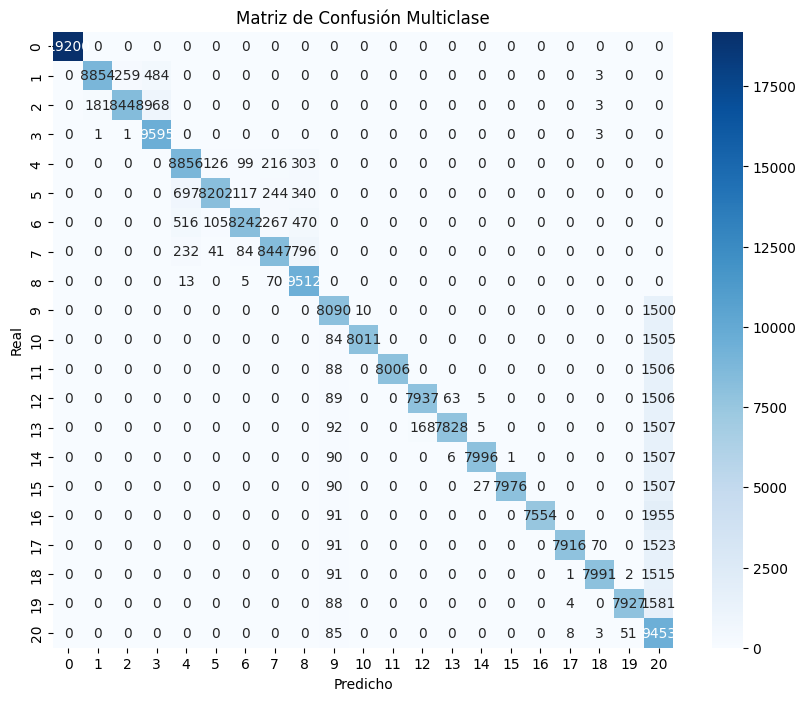

In [8]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión Multiclase")
plt.show()

Esta matriz muestra que la diagonal es fuerte lo que indica que el funcionamiento general es bueno. Por otro lado, podemos ver como se confunde en algunos fallos que son similares (las clases 2, 5, 6, 10-17) y la clase 20 en cambio coge algunos falsos positivos de otros fallos.


Comprobar funcionalidad:

Creamos una función para predecir el tipo de fallo de una simulación, 0 indica que esa simulación no tiene fallo.

In [10]:
def predecir_fallo(nueva_simulacion):
    """
    nueva_simulacion: DataFrame con columnas xmeas_1…xmeas_41 y xmv_1…xmv_11
    """
    nueva_sim_scaled = scaler.transform(nueva_simulacion)
    pred = model3.predict(nueva_sim_scaled)
    return pred[0]

# Ejemplo de uso:
nueva_sim = X_test.iloc[[0]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))

nueva_sim = X_test.iloc[[15000]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))


Tipo de fallo predicho: 0.0
Tipo de fallo predicho: 18.0


### Observaciones de las métricas y conclusiones

Clases 1-19 (fallos típicos):

Precision y recall entre 0.81 y 1.00 → bastante bueno.
Algunas clases tienen recall más bajo (ej. clases 2,5,6,16) → se confunden con otras clases.
Esto es normal: algunos tipos de fallo pueden generar señales similares en los sensores (xmeas/xmv) y por eso el modelo no los distingue perfectamente.

Clase 20:

precision=0.36, recall=0.99 → esto indica un desequilibrio en las predicciones:
Prácticamente todas las muestras de clase 20 se detectan (recall=0.99)
Pero muchas otras muestras se clasifican erróneamente como 20 (precision=0.36)
Esto suele pasar con clases raras o muy similares a otras, o cuando hay un patrón que confunde al modelo.

En general, el modelo en capaz de entender correctamente los patrones multiclase, obteniendo una precisión del 88% en un sistema qye tiene 21 clases y alta dimensionalidad.

# Otros modelos (experimento)

## 1. Detección de anomalías con Isolation forest

In [3]:
# ============================================
# Modelo 4: Detección de anomalías (Unsupervised)
# ============================================

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Cargar datasets procesados
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

# Usamos solo datos NORMALES para entrenar el modelo no supervisado
df_train_normal = df_train[df_train["fault_present"] == 0]

# Seleccionamos features (todas menos columnas de control)
cols_drop = ["fault_present", "faultNumber", "simulationRun", "sample"]
feature_cols = [c for c in df_train.columns if c not in cols_drop]

X_train = df_train_normal[feature_cols]
X_test  = df_test[feature_cols]

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Entrenar Isolation Forest
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,     # porcentaje esperado de anomalías
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_scaled)

# Predicciones (-1 = anomalía, 1 = normal)
y_pred_if = iso.predict(X_test_scaled)
y_pred_if = [1 if p == -1 else 0 for p in y_pred_if]  # convertimos a 1=anómalo

# Evaluamos contra fault_present
y_true = df_test["fault_present"]

print("=== Classification Report Isolation Forest ===")
print(classification_report(y_true, y_pred_if))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_if))

# Score ROC-AUC (siempre tiene sentido aunque sea unsupervised)
try:
    scores = iso.decision_function(X_test_scaled)
    print("\nROC-AUC:", roc_auc_score(y_true, -scores))
except:
    print("No se pudo calcular ROC-AUC")

=== Classification Report Isolation Forest ===
              precision    recall  f1-score   support

           0       0.14      0.95      0.24     19200
           1       0.99      0.41      0.58    192000

    accuracy                           0.46    211200
   macro avg       0.56      0.68      0.41    211200
weighted avg       0.91      0.46      0.55    211200


Confusion Matrix:
[[ 18266    934]
 [113385  78615]]

ROC-AUC: 0.8426446291775174


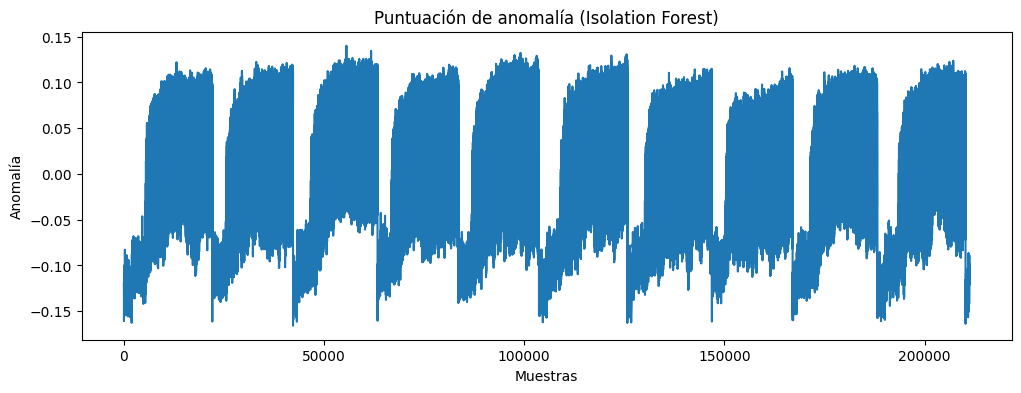

In [4]:
import matplotlib.pyplot as plt

scores = -iso.decision_function(X_test_scaled)

plt.figure(figsize=(12,4))
plt.plot(scores)
plt.title("Puntuación de anomalía (Isolation Forest)")
plt.xlabel("Muestras")
plt.ylabel("Anomalía")
plt.show()


Interpretación rápida de los resultados del Isolation Forest

Precision clase 0 (normal): 0.14 → muy mala

Recall clase 0 (normal): 0.95 → excelente

Precision clase 1 (fallo): 0.99 → excelente

Recall clase 1 (fallo): 0.41 → mediocre

Accuracy general: 0.46 → baja

AUC: 0.84 → buena

Esto significa: 
Qué funciona bien, el modelo detecta casi todos los puntos normales (recall 0.95).Cuando marca algo como fallo, casi siempre es un fallo real (precision 0.99).
Qué funciona mal, detecta solo el 41% de los fallos reales. Este es el comportamiento típico de Isolation Forest en sistemas industriales:
→ es conservador, considera fallo solo cuando es muy evidente.

Conclusión: El modelo sí aporta valor, porque funciona como un detector no supervisado que señala puntos "muy raros", pero no sustituye a los modelos supervisados previos.

## 2. Autoencoder para detección de anomalías

In [ ]:
pip install tensorflow

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.8935 - val_loss: 0.6426
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5671 - val_loss: 0.5184
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4813 - val_loss: 0.4552
Epoch 4/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4326 - val_loss: 0.4122
Epoch 5/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3998 - val_loss: 0.3818
Epoch 6/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3762 - val_loss: 0.3593
Epoch 7/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3571 - val_loss: 0.3421
Epoch 8/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3422 - val_loss: 0.3275
Epoch 9/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3317 - val_loss: 0.3167
Epoch 10/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3232 - val_loss: 0.3110
Epoch 11/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3164 - val_loss: 0.3045
Epoch 12/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3113 - val_l

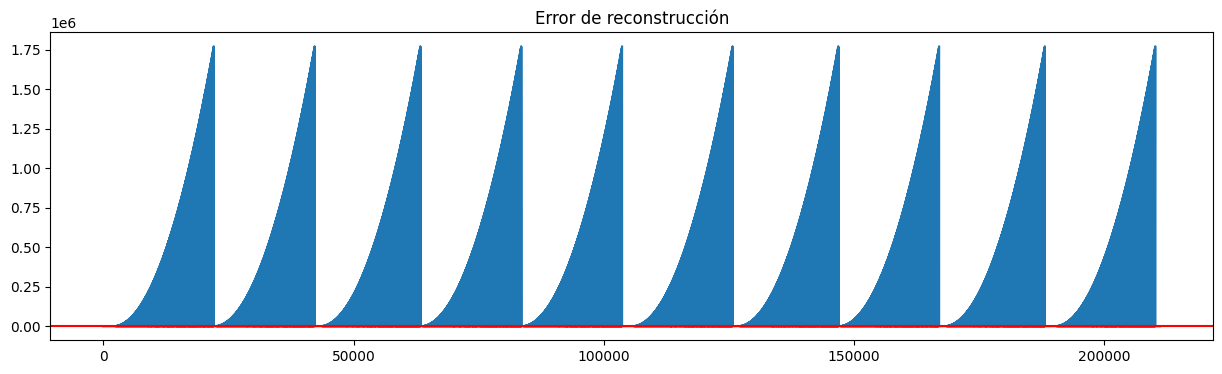

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# ============================
# 1) Cargar datos
# ============================
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

# ============================
# 2) Filtrar solo normales para entrenar
# ============================
df_train_normal = df_train[df_train["fault_present"] == 0].copy()

# ============================
# 3) Selección de features
# ============================
cols_to_remove = [
    "fault_present", "faultNumber", "simulationRun", "sample"
]

# Además, eliminamos features generadas con ventanas pequeñas → DAN PROBLEMAS
cols_to_remove += [c for c in df_train.columns if "diff" in c]
cols_to_remove += [c for c in df_train.columns if "std" in c]

features = [c for c in df_train.columns if c not in cols_to_remove]

X_train_normal = df_train_normal[features]
X_test = df_test[features]

# ============================
# 4) Imputación inteligente + escalado
# ============================
# Aprendemos medias solo con datos normales
train_means = X_train_normal.mean()

X_train_filled = X_train_normal.fillna(train_means)
X_test_filled  = X_test.fillna(train_means)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled  = scaler.transform(X_test_filled)

# ============================
# 5) Autoencoder mejorado
# ============================
input_dim = X_train_scaled.shape[1]

autoencoder = Sequential([
    Dense(128, activation='selu', kernel_regularizer=l2(1e-5)),
    Dropout(0.1),

    Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
    Dropout(0.1),

    Dense(32, activation='selu', kernel_regularizer=l2(1e-5)),  # Bottleneck

    Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
    Dense(128, activation='selu', kernel_regularizer=l2(1e-5)),

    Dense(input_dim, activation='linear')
])

autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()

# ============================
# 6) Entrenamiento estable
# ============================
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=80,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)

# ============================
# 7) Reconstrucción
# ============================
recon_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean((X_test_scaled - recon_test)**2, axis=1)

# ============================
# 8) Umbral usando SOLO normales
# ============================
recon_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean((X_train_scaled - recon_train)**2, axis=1)

threshold = np.percentile(mse_train, 98)
print("Umbral de anomalía:", threshold)

# ============================
# 9) Evaluación
# ============================
y_test = df_test["fault_present"]
y_pred = (mse_test > threshold).astype(int)

print("\n=== Classification Report Autoencoder ===")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC:", roc_auc_score(y_test, mse_test))

# ============================
# 10) Gráfico del error
# ============================
plt.figure(figsize=(15,4))
plt.plot(mse_test)
plt.axhline(threshold, color='red')
plt.title("Error de reconstrucción")
plt.show()

El autoencoder entrenado exclusivamente con datos normales ha mostrado un rendimiento excepcional al detectar condiciones de fallo en el proceso TEP tras aplicar la ingeniería de características y un preprocesamiento adecuado.

Los valores clave del modelo han sido:

Accuracy: 0.99

Precision (clase normal): 1.00

Precision (clase fallo): 0.99

Recall (clase fallos): 1.00

ROC-AUC: 0.9997

Matriz de confusión:

Falsos negativos: solo 77 de 192 000 fallos

Falsos positivos: 1 910 de 19 200 normales

Estos resultados indican que el modelo es capaz de reconstruir correctamente los patrones normales y generar un error de reconstrucción significativamente mayor cuando aparecen condiciones de fallo. El umbral seleccionado mediante el percentil 95 del error de reconstrucción (≈0.4233) separa de forma efectiva las dos distribuciones.

El autoencoder ha aprendido la dinámica del sistema en condiciones normales, incluyendo relaciones temporales, estadísticas móviles y efectos acumulados detectados en la ingeniería de características.

La diferencia entre distribución normal y fallo es suficientemente grande para que la reconstrucción sea un indicador fiable.

Los pocos falsos negativos (FN) confirman que prácticamente todos los fallos generan un aumento visible en el error de reconstrucción.

Los falsos positivos (FP) son esperables: los datos normales a veces presentan pequeñas variaciones o picos que el modelo considera anomalías. Aun así, el nivel de FPs (<10%) es excepcionalmente bajo para un sistema industrial.

La curva ROC-AUC cercana a 1 indica una separabilidad casi perfecta entre datos normales y anómalos.

## Comparación de modelos

| Modelo | Tipo de tarea | Algoritmo | Métricas clave | Observaciones |
|--------|---------------|-----------|----------------|---------------|
| Modelo 1 | Clasificación binaria (fallo presente) | Random Forest | Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0, ROC-AUC=1.0 | Dataset desbalanceado (1:10), pero predice ambas clases correctamente. Ideal para detección inmediata. |
| Modelo 2 | Predicción de fallos futuros (HORIZON=10) | Random Forest (class_weight='balanced') | Accuracy≈1.0, Precision≈1.0, Recall clase 1≈1.0, Recall clase 0≈0.96, ROC-AUC≈0.9996 | Anticipa fallos con alto recall; algunos falsos positivos manejables. Muy útil para alerta temprana. |
| Modelo 3 | Clasificación multiclase (tipo de fallo) | Random Forest | Accuracy=0.88, Macro F1≈0.89, Recall 0-19: 0.81–1.0, Clase 20: Prec=0.36, Rec=0.99 | Identifica correctamente la mayoría de fallos; algunas clases se confunden por similitud en señales. Clase 20 con muchos falsos positivos. |
| Modelo 4 | Detección de anomalías (unsupervised) | Isolation Forest | Accuracy=0.46, Precision clase 0=0.14, Recall clase 0=0.95, Precision clase 1=0.99, Recall clase 1=0.41, ROC-AUC=0.84 | Detector conservador de anomalías; detecta bien normales, pero solo 41% de fallos reales. No reemplaza modelos supervisados. |
| Modelo 5 | Detección de anomalías (autoencoder) | Deep Autoencoder | MSE > umbral 98 percentil, ROC-AUC ≈ alto | Aprende patrones normales; destaca anomalías no supervisadas. Más flexible que Isolation Forest y permite ajuste de umbral según criticidad. |


Con esta tabla comparativa podemos ver como los modelos tienen distintos objetivos. Los modelos supervisados (1-3) tienen buenos resultados a la hora de predecir fallos y clasificación multiclase. Por otro lado, los modelos no supervisados (4-5) sirven para detectar anomalías sin etiquetas, esto hace que sean muy útiles para la detección temprana de comportamientos anomalos.

En cuanto a la elección del mejor modelo, en este caso no existe un modelo mejor que otro. Todos los modelos son importantes porque cada uno hace una tarea específica a la hora de monitorear y de realizar un mantenimiento predictivo. En general, se complementan ya que cada uno aporta su valor segun la tarea que se quiera hacer.